In [66]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools
import json 
from scipy.stats import gmean 

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
print('mp_1 genome size: ', fasta_get_genome_size('../data/data/mp_1.fn'))
print('mp_2 genome size: ', fasta_get_genome_size('../data/data/mp_2.fn'))

mp_1 genome size:  2511192
mp_2 genome size:  546039


In [68]:
# Want to see if there are any transcriptional changes which are correlated with the decrease in ECEs between 2024 and 2025. 

metat_df = metat_load()

mp_metat_df = metat_df[metat_df.target_name.str.startswith('mp_')].copy()
mp_metat_df = pd.concat([metat_filter(df, threshold=10, min_samples=2, field='read_count') for _, df in mp_metat_df.groupby('target_name', group_keys=True)])
mp_metat_df = mp_metat_df[mp_metat_df.reactor == 'n'].copy() # Focus on the nitrate reactor. 

interproscan_df = load_interproscan().rename(columns={'id':'gene_id'})[['target_name', 'gene_id', 'signature_description', 'signature_accession', 'e_value']]
interproscan_df = interproscan_df[is_mp(interproscan_df)]
mp_metat_df = mp_metat_df.merge(interproscan_df, on=['target_name', 'gene_id'], how='left')
mp_metat_df = mp_metat_df.sort_values('e_value').drop_duplicates(['target_name', 'sample_id', 'gene_id'])

filter_: Keeping 925 out of 2875 total genes for mp_1.
filter_: Keeping 111 out of 613 total genes for mp_2.
filter_: Keeping 518 out of 3055 total genes for mp_3.
filter_: Keeping 526 out of 3537 total genes for mp_4.
filter_: Keeping 590 out of 2733 total genes for mp_5.


In [69]:
# Archaea should have 12 RNA polymerase subunits, Rpo1a, Rpo1b (split beta subunit), Rpo2, ... Rpo12. 
# It seems like the core set Rpo1a, Rpo1b, Rpo2, and Rpo3, and Rpo4 are the largest subunits, and also highly-conserved (except Rpo4, but Methanoperedens has it). 
rnap_signatures = np.loadtxt('../data/rnap_signatures.txt', dtype=str).tolist()
ef2_signatures = np.loadtxt('../data/ef2_signatures.txt', dtype=str).tolist()
cca_signatures = np.loadtxt('../data/cca_signatures.txt', dtype=str).tolist()

_get_genes = lambda df : list(set([tuple(gene) for gene in zip(df.target_name, df.gene_id)]))

warnings.simplefilter('ignore')
rnap_genes = interproscan_df[interproscan_df.signature_accession.isin(rnap_signatures)].groupby('target_name').apply(_get_genes, include_groups=True).to_dict()
ef2_genes = interproscan_df[interproscan_df.signature_accession.isin(ef2_signatures)].groupby('target_name').apply(_get_genes, include_groups=True).to_dict()
cca_genes = interproscan_df[interproscan_df.signature_accession.isin(cca_signatures)].groupby('target_name').apply(_get_genes, include_groups=True).to_dict()

# with open('../data/ref_genes.json', 'w') as f:
#     json.dump(ref_genes, f)

In [70]:
def get_genes(df, genes):
    index = list(zip(df.target_name.values, df.gene_id.values))
    return [(gene in genes) for gene in index]

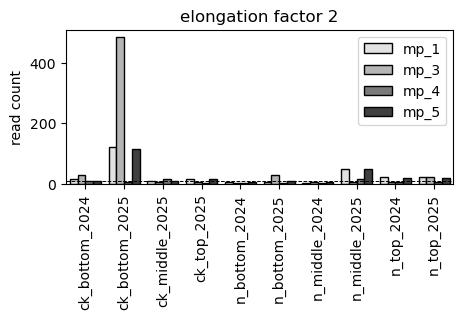

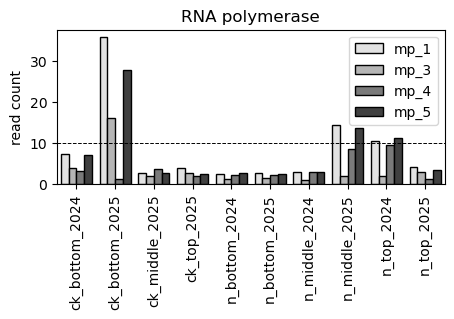

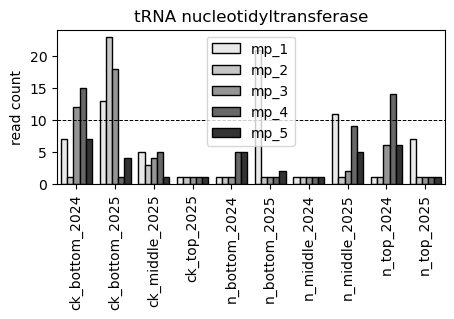

In [71]:
# Nature of the filtering is that if a reference is included in one organism, it is included in all instances of that organism across samples. 

def plot_ref_read_counts(metat_df, ref_genes:dict=None, title=''):
    fig, ax = plt.subplots(figsize=(5, 2))
    ref_genes = [tuple(gene) for gene in np.concat(list(ref_genes.values()))]

    figure_df = metat_df.copy()
    figure_df = figure_df.sort_values(['sample_id', 'target_name'], ascending=False)
    figure_df = figure_df[get_genes(figure_df, ref_genes)].copy()

    figure_df = metat_add_pseudocounts(figure_df, method='ones')
    # get_gmean = lambda df : gmean(df.read_count[df.read_count > 0].values)
    get_gmean = lambda df : gmean(df.read_count.values)
    
    figure_df = figure_df.groupby(['sample_id', 'target_name']).apply(get_gmean).reset_index(name='read_count')
    sns.barplot(figure_df, x='sample_id', hue='target_name', palette='Grays', y='read_count', edgecolor='black')
    ax.set_ylabel('read count')
    ax.set_title(title)
    ax.get_legend().set_title('')
    ax.set_xlabel('')
    ax.set_xticks(ax.get_xticks(), [label.get_text().replace('_metat', '') for label in ax.get_xticklabels()], rotation=90)
    ax.axhline(10, ls='--', lw=0.7, color='black')
    plt.show()

plot_ref_read_counts(metat_df, ref_genes=ef2_genes, title='elongation factor 2')
plot_ref_read_counts(metat_df, ref_genes=rnap_genes, title='RNA polymerase')
plot_ref_read_counts(metat_df, ref_genes=cca_genes, title='tRNA nucleotidyltransferase')



In [72]:
# def figure(metat_df:pd.DataFrame, ref_genes:):

#     fig, ax = plt.subplots()

#     # Presence and absence heatmap 

In [73]:
def get_differential_expression(metat_df:pd.DataFrame, var_col='year'):
    diff_df = list()

    sample_metadata_cols = ['location', 'reactor', 'year']
    var_cols = [col for col in metat_df.columns if (re.search('_alr|_clr', col) is not None)] + ['read_count', 'read_count_original', 'coverage', 'sample_id']
    fixed_cols = [col for col in metat_df.columns if (col not in var_cols)]

    for _, df in tqdm(metat_df.groupby([col for col in sample_metadata_cols if (col != var_col)] + ['gene_id', 'target_name']), 'get_differential_expression'):
        comparisons = list(itertools.combinations(df[var_col].unique(), 2))
        df.index = df[var_col] # Set a new index and keep the var_col. 
        for v_1, v_2 in comparisons:
            v_1, v_2 = sorted([v_1, v_2])
            row = df[fixed_cols].iloc[0].to_dict() # Initialize row with fixed metadata
            row[f'{var_col}_1'], row[f'{var_col}_2'] = v_1, v_2 
            row.update({f'{col}_1':value for col, value in df.loc[v_1, var_cols].to_dict().items()})
            row.update({f'{col}_2':value for col, value in df.loc[v_2, var_cols].to_dict().items()})
            diff_df.append(row)

    diff_df = pd.DataFrame(diff_df)
    # No comparisons where both measurements are zero are valid, basically just comparing pseudocounts. 
    mask = (diff_df.read_count_original_1 == 0) & (diff_df.read_count_original_2 == 0)
    print(f'get_differential_expression: Removing {mask.sum()} paired measurements where both measures are zero.')
    return diff_df

# mp_metat_df = metat_normalize(mp_metat_df.copy(), ref_genes=ref_genes, method='alr')
mp_metat_df = metat_normalize(mp_metat_df, ref_genes=dict(), method='clr')
mp_metat_diff_df = get_differential_expression(mp_metat_df)
mp_metat_diff_df['read_count_normalized_clr_diff'] = mp_metat_diff_df.read_count_normalized_clr_2 - mp_metat_diff_df.read_count_normalized_clr_1

get_differential_expression: 100%|██████████| 8010/8010 [00:11<00:00, 714.55it/s]


get_differential_expression: Removing 1224 paired measurements where both measures are zero.


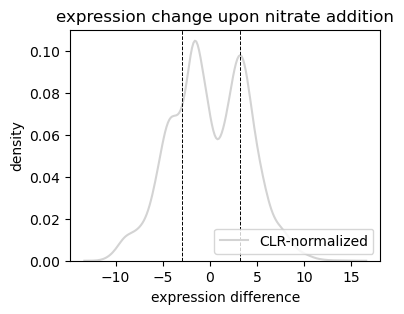

In [74]:
downregulation_threshold = np.quantile(mp_metat_diff_df.read_count_normalized_clr_diff, 0.25)
upregulation_threshold = np.quantile(mp_metat_diff_df.read_count_normalized_clr_diff, 0.75)

def plot_diff_distribution(diff_df:pd.DataFrame, upregulation_threshold=upregulation_threshold, downregulation_threshold=downregulation_threshold):
    fig, ax = plt.subplots(figsize=(4, 3))
    figure_df = diff_df.copy()
    # sns.kdeplot(figure_df, x='read_count_normalized_alr_diff', label='ALR-normalized', color='gray')
    sns.kdeplot(figure_df, x='read_count_normalized_clr_diff', label='CLR-normalized', color='lightgray')
    ax.set_ylabel('density')
    ax.set_title('expression change upon nitrate addition')
    ax.set_xlabel('expression difference')
    ax.legend()
    sns.move_legend(ax, loc='lower right')
    ax.axvline(downregulation_threshold, ls='--', lw=0.7, color='black')
    ax.axvline(upregulation_threshold, ls='--', lw=0.7, color='black')
    plt.show()

plot_diff_distribution(mp_metat_diff_df)

# Primary difference in the normalization approaches seems to be the spike in up-regulated sequences under CLR normalization.

# My concern is that the CLR normalization means that geometric mean is overly-low in the sparse samples due to an increase in counting
# errors, which could make it appear as though (1) genes with moderate-to-low expression that are randomly detected are expressed more highly 
# and (2) genes which are moderately expressed in both 2024 and 2025 samples are up-regulated in the 2025 samples. 

# Key assumption underlying CLR normalization for DE analysis is that the baseline level of transcription is comparable across samples. 
# However, I don't think we can make that assumption here. 

# Based on the plot below, what seems to have happened is that the CLR normalization selected values skewed to the right in the high-abundance
# samples and skewed to the left in the low-abundance samples, resulting in a bimodal distribution. 


In [75]:
def get_loadings(pca, pca_df, quantile:float=0.75):
    # PCA explained variance has shape (n_features,), and the components are shape (n_namples, n_features). Want to get the importance
    # of each feature, which is the total magnitude of the loading. 
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_) # PCA explained_variance_ attribute contains the eigenvalues. 
    loadings_df = pd.DataFrame(loadings, index=pca_df.columns)
    loadings_df['total'] = np.sqrt(loadings_df[0] ** 2 + loadings_df[1] ** 2)

    upper_quantile_threshold = np.quantile(loadings_df['total'].values, quantile)
    loadings_df = loadings_df[loadings_df['total'] > upper_quantile_threshold].copy()
    return loadings_df.sort_values('total', ascending=False)

In [76]:
get_zero_fraction = lambda df : {sample_id:(df_.read_count_original == 0).mean() for sample_id, df_ in df.groupby('sample_id')}
zero_fractions = {target_name:get_zero_fraction(df) for target_name, df in mp_metat_df.groupby('target_name')}

PCA explained variance: 57.45%


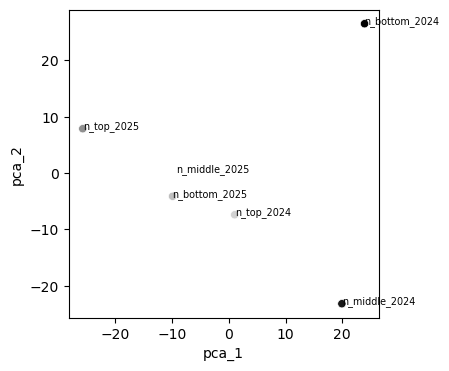

In [77]:
# Probably the easiest way to pick out changes is to look at each Methanoperedens strain individually. 

# Want to figure out which gene expression changes are most responsible for the 2024 to 2025 differences. To do this, 
# will need to produce feature-sample matrices, where each feature is a gene and each row is a sample. Want to make sure
# the values are *not* already the differences. 

normalization = 'clr'
target_name = 'mp_1'
hue = 'zero_fraction'

df = mp_metat_df.copy()
df = df[df.target_name == target_name].copy()

pca_df = df.pivot(values=f'read_count_normalized_{normalization}', index='sample_id', columns='gene_id').fillna(0)

pca = PCA(n_components=2)
components = pca.fit_transform(StandardScaler().fit_transform(pca_df.values))
print(f'PCA explained variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%')

fig, ax = plt.subplots(figsize=(4, 4))
figure_df = pd.DataFrame(components, index=pca_df.index, columns=['pca_1', 'pca_2'])
figure_df['year'] = [re.search('2024|2025', sample_id).group(0) for sample_id in figure_df.index]
figure_df['reactor'] = [re.search('ck_|n_', sample_id).group(0) for sample_id in figure_df.index]
figure_df['location'] = [re.search('top|bottom|middle', sample_id).group(0) for sample_id in figure_df.index]
figure_df['zero_fraction'] = figure_df.index.map(zero_fractions[target_name]) 
sns.scatterplot(figure_df, x='pca_1', y='pca_2', hue=hue, palette='Grays',legend=False)

for row in figure_df.itertuples():
    ax.text(row.pca_1, row.pca_2, row.Index.replace('_metat', ''), fontsize='x-small')
plt.show()

loadings_df = get_loadings(pca, pca_df)
# loadings_df['signature_description'] = loadings_df.index.map(diff_df.drop_duplicates('gene_id').set_index('gene_id').signature_description)

In [78]:
col = f'read_count_normalized_clr_diff'
n = 2
_is_consistently_regulated = lambda df : (len(df) > 0) and np.all(np.sign(df[col].values) == np.sign(df[col].values[0]))
_is_significantly_regulated = lambda df : _is_consistently_regulated(df) and (((df[col].values < downregulation_threshold).sum() > n) or ((df[col].values > upregulation_threshold).sum() > n))

def is_consistently_regulated(diff_df:pd.DataFrame):
    '''Flag genes that are consistently up- or down- regulated across samples.'''
    genes = [gene for gene, df in diff_df.groupby(['target_name', 'gene_id']) if _is_consistently_regulated(df)]
    print(f'is_consistently_regulated: Found {len(genes)} genes which are consistently-regulated.')
    return get_genes(diff_df, genes)

def is_significantly_regulated(diff_df:pd.DataFrame):
    '''Flag genes that exceed the minimum threshold in at least min_n_samples.'''
    genes = [gene for gene, df in diff_df.groupby(['target_name', 'gene_id']) if _is_significantly_regulated(df)]
    print(f'is_significantly_regulated: Found {len(genes)} genes which are significantly-regulated.')
    return get_genes(diff_df, genes)

mp_metat_diff_df['consistently_regulated'] = is_consistently_regulated(mp_metat_diff_df)
mp_metat_diff_df['significantly_regulated'] = is_significantly_regulated(mp_metat_diff_df)
mp_metat_diff_df = mp_metat_diff_df.sort_values(['read_count_normalized_clr_diff', 'gene_id'])

is_consistently_regulated: Found 908 genes which are consistently-regulated.
is_significantly_regulated: Found 164 genes which are significantly-regulated.


In [79]:
interproscan_df = load_interproscan().rename(columns={'id':'gene_id'})[['target_name', 'gene_id', 'signature_description', 'signature_accession', 'e_value']]
interproscan_df = interproscan_df[interproscan_df.e_value < 1e-1].sort_values('e_value').copy()
interproscan_df = interproscan_df[(interproscan_df.signature_description != '-')].copy() # Get rid of the useless annotations for the plot. 

In [80]:
mp_metat_diff_df[mp_metat_diff_df.significantly_regulated & (mp_metat_diff_df.target_name == 'mp_2')]

,gene_id,contig,start,end,strand,length,target_name,library_size,location,reactor,...,sample_id_1,normalization_factor_clr_2,read_count_normalized_clr_2,read_count_2,read_count_original_2,coverage_2,sample_id_2,read_count_normalized_clr_diff,consistently_regulated,significantly_regulated


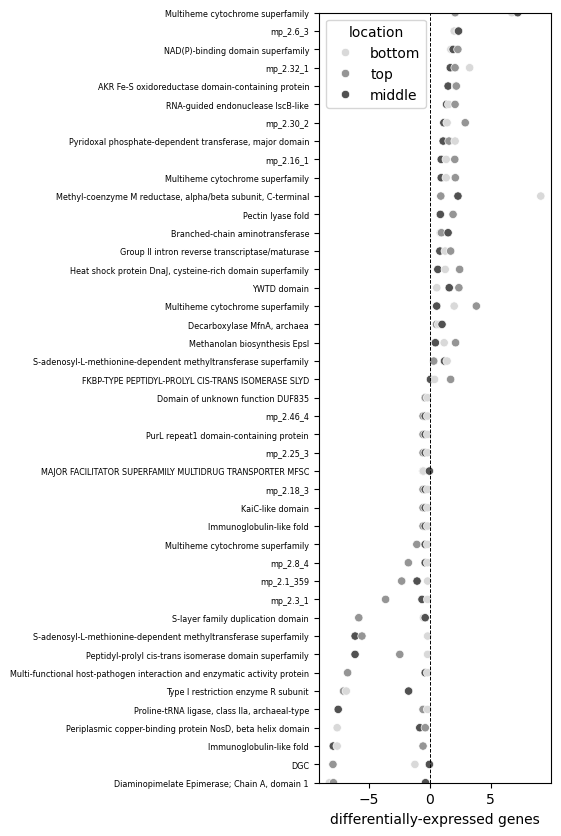

In [85]:
def plot_diff(diff_df:pd.DataFrame, genes:list=None, normalization='clr', annotations=dict(), legend:bool=True, hue:str='year', annotated_only:bool=False):
    
    fig, ax = plt.subplots(figsize=(3, 10))
    figure_df = diff_df[get_genes(diff_df, genes)].copy()
    # figure_df['gene'] = [str((row.target_name, row.gene_id)) for row in figure_df.itertuples()]
    figure_df['gene'] = [f'{row.target_name}.{row.gene_id}' for row in figure_df.itertuples()]
    sns.scatterplot(figure_df, y='gene', x=f'read_count_normalized_{normalization}_diff', hue=hue, palette='Grays', legend=legend)
    ax.axvline(0, color='black', lw=0.7, ls='--')

    annotations = {f'{target_name}.{gene_id}':annotation for (target_name, gene_id), annotation in annotations.items()}

    labels = [annotations.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
    # labels = [annotations.get(label.get_text(), label.get_text()) + f' ({label.get_text()})' for label in ax.get_yticklabels()]
    ax.set_yticks(ax.get_yticks(), labels, fontsize='xx-small')
    ax.set_ylabel('')
    ax.set_ylim(ymin=0, ymax=ax.get_yticks()[-1])
    ax.set_xlabel('differentially-expressed genes')
    plt.show()

mp_1_genes = [(row.target_name, row.gene_id) for row in mp_metat_diff_df[mp_metat_diff_df.significantly_regulated & (mp_metat_diff_df.target_name == 'mp_1')].itertuples()]
mp_1_annotations = interproscan_df[get_genes(interproscan_df, mp_1_genes)].drop_duplicates(['target_name', 'gene_id']).set_index(['target_name', 'gene_id']).signature_description.to_dict()

# mp_2_genes = [(row.target_name, row.gene_id) for row in mp_metat_diff_df[mp_metat_diff_df.significantly_regulated & (mp_metat_diff_df.target_name == 'mp_2')].itertuples()]
# mp_2_annotations = interproscan_df[get_genes(interproscan_df, mp_2_genes)].drop_duplicates(['target_name', 'gene_id']).set_index(['target_name', 'gene_id']).signature_description.to_dict()
mp_2_genes = [(row.target_name, row.gene_id) for row in mp_metat_diff_df[mp_metat_diff_df.consistently_regulated & (mp_metat_diff_df.target_name == 'mp_2')].itertuples()]
mp_2_annotations = interproscan_df[get_genes(interproscan_df, mp_2_genes)].drop_duplicates(['target_name', 'gene_id']).set_index(['target_name', 'gene_id']).signature_description.to_dict()

mp_5_genes = [(row.target_name, row.gene_id) for row in mp_metat_diff_df[mp_metat_diff_df.significantly_regulated & (mp_metat_diff_df.target_name == 'mp_5')].itertuples()]
mp_5_annotations = interproscan_df[get_genes(interproscan_df, mp_5_genes)].drop_duplicates(['target_name', 'gene_id']).set_index(['target_name', 'gene_id']).signature_description.to_dict()

mp_3_genes = [(row.target_name, row.gene_id) for row in mp_metat_diff_df[mp_metat_diff_df.significantly_regulated & (mp_metat_diff_df.target_name == 'mp_3')].itertuples()]
mp_3_annotations = interproscan_df[get_genes(interproscan_df, mp_3_genes)].drop_duplicates(['target_name', 'gene_id']).set_index(['target_name', 'gene_id']).signature_description.to_dict()

plot_diff(mp_metat_diff_df, genes=mp_2_genes, annotations=mp_2_annotations, hue='location')
# plot_diff(mp_metat_diff_df, genes=nif_genes, annotations=nif_annotations, hue='location')



In [82]:

# # Already filtering for consistent up- or down- regulation across all three comparisons. 
# figure_df = mp_metat_diff_df[mp_metat_diff_df.significantly_regulated].copy()
# figure_df = figure_df.merge(cluster_df[['gene_id', 'target_name', 'cluster_id']], on=['target_name', 'gene_id'], how='left')
# figure_df = figure_df.drop_duplicates(['gene_id', 'target_name']).copy()
# cluster_counts = figure_df.cluster_id.value_counts()
# cluster_counts = cluster_counts[cluster_counts >= 2]
# cluster_ids = cluster_counts.index.values
# print('Num. clusters meeting threshold:', len(cluster_counts))
# figure_df = figure_df[figure_df.cluster_id.isin(cluster_counts.index.values)]
# figure_df['cluster_id'] = figure_df.cluster_id.astype(str)
# sns.histplot(figure_df, x='cluster_id', hue='target_name', multiple='stack', discrete=True)
# # df = df.drop_duplicates(['target_name', 'gene_id', 'sample_id']).drop(columns='sample_id')
# # df = df.drop(columns=['signature_accession', 'signature_description', 'e_value']).merge(interproscan_df, on=['target_name', 'gene_id'], how='left')
# # df['regulation'] = np.where(df.read_count_normalized_alr_diff > 0, 'up', 'down')


# figure_df[figure_df.cluster_id.isin(cluster_counts.index.values)]
# # Want a way to show that certain clusters are up-regulated across organisms and samples. 


In [83]:
# mp_metat_diff_df[mp_metat_diff_df.consistently_regulated].copy().drop_duplicates('sample_id').drop(columns='sample_id')
mp_metat_diff_df.drop_duplicates('sample_id').consistently_regulated.sum()

KeyError: Index(['sample_id'], dtype='object')

In [ ]:
# mp_ribosome_proteins_df = pd.read_csv('mp_ribosome_proteins.csv', index_col=0)
# mp_ribosome_proteins_df = mp_ribosome_proteins_df.sort_values('e_value').drop_duplicates(['target_name', 'product'])
# mp_ribosome_proteins_df = mp_ribosome_proteins_df.merge(mp_metat_df[['target_name', 'gene_id', 'read_count', 'sample_id']], on=['gene_id', 'target_name'])
# print('Num. annotated ribosomal proteins:', mp_ribosome_proteins_df['product'].nunique())

# # For ALR, need genes detected in all samples and all strains. 

# figure_df = pd.DataFrame(index=mp_ribosome_proteins_df['product'].unique(), columns=mp_ribosome_proteins_df.target_name.unique())
# for (protein, target_name), df in mp_ribosome_proteins_df[mp_ribosome_proteins_df.read_count > 0].groupby(['product', 'target_name']):
#     figure_df.loc[protein, target_name] = df.sample_id.nunique()

# figure_df['total'] = figure_df.sum(axis=1)
# figure_df.sort_values('total')
# figure_df = figure_df[figure_df.total > 5]
# # mp_ribosome_proteins_df = mp_ribosome_proteins_df[mp_ribosome_proteins_df['product'].isin(figure_df.index)]
# figure_df

# fig, ax = plt.subplots(figsize=(15, 3))

# target_name = 'mp_1'
# figure_df = mp_ribosome_proteins_df.copy()
# figure_df = figure_df[figure_df.read_count < 300].copy()
# # sns.stripplot(figure_df, x='product', y='read_count', hue='target_name', palette='Grays')
# figure_df = figure_df[figure_df.target_name == target_name].copy()
# sns.boxplot(figure_df, x='product', y='read_count', color='lightgray', showfliers=False)
# sns.stripplot(figure_df, x='product', y='read_count', color='gray')
# ax.set_xlabel('')
# ax.set_ylabel('read count')

# ax.set_ylim(ymax=30, ymin=0)# For ALR normalization, need "housekeeping" genes whose expression should track baseline transcriptional activity, and 
# # not vary much by condition. Also want to make sure they are (1) annotated in all the Methanoperedens genomes to allow interstrain
# # comparison, (2) are expressed in the majority of samples. Also need to be careful with the ribosomal proteins, as some seem to have multiple copies.

# # ref_signature_descriptions = ['CDC48 family AAA ATPase'] # Seems to be multiple copies of this, also maybe not super stable. 
# ref_signature_descriptions = list()
# ref_signature_descriptions += ['elongation factor EF-2']
# ref_signature_descriptions += ['DNA dependent RNA-polymerase']
# ref_signature_descriptions += ['DNA polymerase II large subunit']
# ref_signature_descriptions += ['DNA gyrase subunit A']
# # ref_signature_descriptions += ['DNA gyrase subunit B']

# # ref_mp_metat_df = mp_metat_df[mp_metat_df.signature_description.isin(ref_signature_descriptions)].copy()
# ref_mp_metat_df = mp_metat_df[mp_metat_df.signature_description.fillna('none').str.contains('|'.join(ref_signature_descriptions))].copy()
# ref_mp_metat_df = ref_mp_metat_df.drop_duplicates(['target_name', 'gene_id', 'sample_id'])

# ref_sample_count_df = ref_mp_metat_df[ref_mp_metat_df.read_count > 0].groupby(['target_name', 'signature_description']).size().reset_index(name='sample_count')
# ref_mp_metat_df = ref_mp_metat_df.merge(ref_sample_count_df, on=['target_name', 'signature_description'])

# ef2_ref_genes = ref_mp_metat_df[ref_mp_metat_df.signature_description == 'elongation factor EF-2'].set_index('target_name').gene_id.to_dict()
# ref_sample_count_df
# plt.show()

# From https://academic.oup.com/gigascience/article/8/9/giz107/5572529, use the genometric mean of the reference proteins.
# In this case, will need to make sure at least a couple of each of the potential reference proteins is expressed in each 
# Methanoperedens strain in each sample. Perhaps use the geometric mean of the nonzero ones? Though perhaps makes more sense to 
# use all which are detected in each genome. Maybe check correlation between metagenome abundance and the ribosome genes. 

In [ ]:
# Unclear if I specifically need to use CLR-normalized reads for PCA, or if any log-ratio based normalization would work. 

In [ ]:
# Using the CLR-normalized expression normalized within a particular sample to compare across samples could be problematic. 
# Although it avoids problems relating to the inconsistent Methanoperedens abundance, it assumes that most genes in the sample
# are not differentially-expressed, i.e. hover around a "baseline" level of expression. If this is not true (for example, if a whole slew
# of genes is up-regulated), the CLR mean would be skewed, and some genes might show up as differentially-regulated when they are 
# at the same expression level. It may be more robust to pick a subset of housekeeping genes against which to compute the ratios (ALR).
# My current idea is to use the mean expression of a subset of genes in each sample, and use that to center the expression
# of other genes in the sample (looking at the log-ratio). Then we can look for consistent patterns of up- or down- regulation. 

# Not completely sure how useful proportionality will be, especially considering that there doesn't seem to be a ton of overlap
# in the genes which are expressed across samples. From https://www.nature.com/articles/s41598-017-16520-0. 

# I think this approach still won't allow for true cross-sample comparison because of changes in Methanoperedens abundance. 

In [ ]:
# # (1) translation elongation factor EF-1 (subunit alpha, which is the longest)
# ef1a_ref_gene_ids = dict()
# ef1a_ref_gene_ids['mp_1'] = '3_75'
# ef1a_ref_gene_ids['mp_3'] = '34_10'
# ef1a_ref_gene_ids['mp_4'] = '34_10'
# ef1a_ref_gene_ids['mp_5'] = '13_70'

# # (2) elongation factor EF-2
# ef2_ref_gene_ids = dict()
# ef2_ref_gene_ids['mp_1'] = '3_76'
# ef2_ref_gene_ids['mp_3'] = '34_9'
# ef2_ref_gene_ids['mp_4'] = '34_9'
# ef2_ref_gene_ids['mp_5'] = '15_29'

# # (3) ribosomal proteins
# p0_ref_gene_ids = dict()
# p0_ref_gene_ids['mp_1'] = '1_195'
# p0_ref_gene_ids['mp_3'] = '123_7'
# p0_ref_gene_ids['mp_3'] = '123_7'
# p0_ref_gene_ids['mp_5'] = '8_15'

# # (4) RNA polymerase Rpb3, there seems the be more expression of this as opposed to Rpb6.
# rpb3_ref_gene_ids = dict()
# rpb3_ref_gene_ids['mp_1'] = '12_45'
# rpb3_ref_gene_ids['mp_3'] = '42_1'
# rpb3_ref_gene_ids['mp_3'] = '42_1'
# rpb3_ref_gene_ids['mp_5'] = '1_196'